핸즈온 7장 앙상블 학습과 랜덤 포레스트 p.245- 257

# CH7 앙상블 학습과 랜덤 포레스트

앙상블 학습

: 일련의 예측기(분류, 회귀 모델)로부터 예측을 수집하면 가장 좋은 모델 하나보다 더 좋은 예측 얻을 수 있음
- 앙상블 : 일련의 예측기
- 앙상블 방법 : 앙상블 학습 알고리즘
 - 배깅, 부스팅, 스태킹 등

랜덤 포레스트

: 결정 트리의 앙상블

## 7.1 투표 기반 분류기

직접 투표 분류기

: 각 분류기의 예측을 모아서 가장 많이 선택된 (다수결 투표로 정해진) 클래스를 예측하는 것

- 약한 학습기일지라도 충분히 많고 다양하다면 앙상블은 강한 학습기가 될 수 있음
- 큰 수의 법칙과 비슷한 원리

여러 분류기를 조합하여 사이킷런의 투표 기반 분류기 (VotingClassifier)를 만들고 훈련시키기

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import numpy as np

import os

In [3]:
#5장에서 소개한 moons dataset 불러오기

from sklearn.datasets import make_moons

from sklearn.model_selection import train_test_split

X,y = make_moons(n_samples=100, noise=0.15)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

각 분류기의 테스트셋 정확도 확인하기

In [5]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 1.0
RandomForestClassifier 1.0
SVC 1.0
VotingClassifier 1.0


투표 기반 분류기의 성능 > 다른 개별 분류기 성능

- 간접 투표 : 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측하기

## 7.2 배깅과 페이스팅

다양한 분류기를 만드는 방법 : 훈련 세트에서 무작위로 샘플링하여 여러 개의 예측기를 훈련하기

- 배깅 : 훈련 세트에서 중복을 허용하여 샘플링하는 방식

- 페이스팅 : 중복을 허용하지 않고 샘플링하는 방식

수집 함수

- 분류 : 통계적 최빈값
- 회귀 : 평균

### 7.2.1 사이킷런의 배깅과 페이스팅

- bootstrap=True : 배깅 사용 (bootstrap=False : 페이스팅 사용)
- n_jobs : 사이킷런이 훈련과 예측에 사용할 CPU 코어 수 지정 ( -1: 가용한 모든 코어를 사용 )

In [6]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=50, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

단일 결정 트리 VS 배깅 앙상블
- 앙상블 예측이 결정 트리 하나의 예측보다 일반화가 잘 됨

 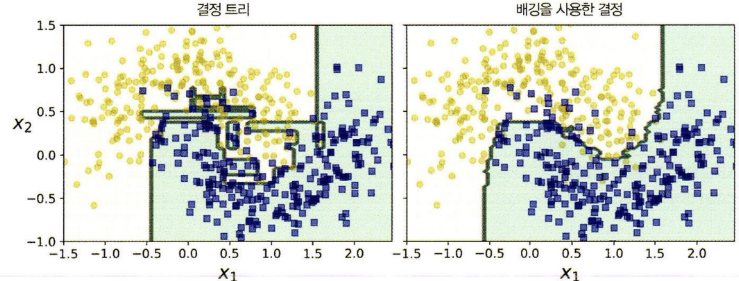

### 7.2.2 oob 평가

배깅 이용하면 어떤 샘플은 여러 번 샘플링, 어떤 것은 전혀 선택되지 않는 경우가 생김
- BaggingClassifier는 중복을 허용하여 훈련 세트의 크기만큼 샘플을 선택함
 - 훈련 샘플의 63% 정도만 샘플링됨
 - 나머지 37%의 샘플은 선택되지 않음

oob 샘플 : 나머지 27%의 훈련 샘플

앙상블의 평가 : 각 예측기의 oob 평가를 평균 (oob_score = True)

In [7]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, bootstrap=True, n_jobs=-1, oob_score=True)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.925

-> oob 평가 결과 : 테스트 세트에서 약 0.9의 정확도

In [8]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

1.0

-> 테스트 세트에서 약 1.0의 정확도

oob 샘플에 대한 결정 함수의 값 확인하기

In [9]:
bag_clf.oob_decision_function_

array([[0.98857143, 0.01142857],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.56613757, 0.43386243],
       [0.01149425, 0.98850575],
       [0.99462366, 0.00537634],
       [0.00529101, 0.99470899],
       [0.07514451, 0.92485549],
       [1.        , 0.        ],
       [0.17142857, 0.82857143],
       [0.65306122, 0.34693878],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.75806452, 0.24193548],
       [0.01117318, 0.98882682],
       [0.        , 1.        ],
       [0.04571429, 0.95428571],
       [0.09433962, 0.90566038],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.98984772, 0.01015228],
       [0.06779661, 0.93220339],
       [0.86187845, 0.13812155],
       [1.        , 0.        ],
       [0.00490196, 0.99509804],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.96987952, 0.03012048],
       [0.        , 1.        ],
       [0.

## 7.3 랜덤 패치와 랜덤 서브스페이스

랜덤 패치 방식 : 훈련 특성과 샘플을 모두 샘플링하는 것

랜덤 서브스페이스 방식 : 훈련 샘플을 모두 사용, 특성은 샘플링하는 것

## 7.4 랜덤 포레스트

랜덤 포레스트 : 일반적으로 배깅 방법을 적용한 결정 트리의 앙상블

In [10]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

랜덤 포레스트 알고리즘 : 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 더 주입함


-> 결국 트리를 더욱 다양하게 만들고 편향을 손해보는 대신 분산을 낮추어 전체적으로 더 훌륭한 모델을 만듦

In [11]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(max_features='auto', max_leaf_nodes=16),
                            n_estimators = 500, max_samples=1.0, bootstrap=True, n_jobs=-1)

### 7.4.1 엑스트라 트리

익스트림 랜덤 트리 앙상블 (엑스트라 트리) : 극단적으로 무작위한 트리의 랜덤 포레스트

편향이 늘어나지만 분산을 낮춤

랜덤 포레스트보다 엑스트라 트리가 훨씬 빠름

### 7.4.2 특성 중요도

랜덤 포레스트
- 장점 : 특성의 상대적 중요도를 측정하기가 쉬움

iris 데이터셋에 RandomForestClassifier를 훈련시키고 각 특성의 중요도를 출력하기

In [12]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_) : print(name, score)

sepal length (cm) 0.09540071918047367
sepal width (cm) 0.02165258519960168
petal length (cm) 0.4369961660573466
petal width (cm) 0.4459505295625781
